In [ ]:
import numpy as np
import os
from PIL import Image

import math
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import cv2


In [ ]:
!pip install imgaug
import imgaug.augmenters as iaa

aug_weak = iaa.RandAugment(n=2, m=4)
aug_strong = iaa.RandAugment(n=2, m=9)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
AUTOTUNE = tf.data.AUTOTUNE


In [ ]:
"""Code to build custom dataset "projsemisup"."""
import tensorflow_datasets.public_api as tfds
import itertools
import pathlib
import os

UNLABELLED = tfds.Split("unlabelled")

COMMIT = "bbebb1e999f95086dc969217d52dc08f95f03f46"
URL = f"https://github.com/axelcarlier/projsemisup/archive/{COMMIT}.zip"
IMG_SHAPE = (128, 128, 3)
CLASSES = [
  "antilope",
  "autruche",
  "Buffle d'Afrique",
  "Chacal",
  "Chimpanzé",
  "Elephant",
  "Girafe",
  "Gnou",
  "Gorilla",
  "Guepard",
  "Hippopotame",
  "hyène",
  "Leopard",
  "Lion",
  "Phacochère",
  "Rhinoceros",
  "tigre",
  "Zèbre",
]

class Projsemisup(tfds.core.GeneratorBasedBuilder):
  """projsemisup dataset."""

  VERSION = tfds.core.Version("1.1.0")

  def _info(self):
    return tfds.core.DatasetInfo(
        builder=self,
        features=tfds.features.FeaturesDict({
            "image": tfds.features.Image(shape=IMG_SHAPE),
            "label": tfds.features.ClassLabel(num_classes=len(CLASSES)),
        }),
        supervised_keys=("image", "label"),
        homepage="https://github.com/axelcarlier/projsemisup/",
    )

  def _split_generators(self, dl_manager):
    """Returns SplitGenerators."""
    # download archive
    archive_path = dl_manager.download_and_extract(URL)
    archive_path = pathlib.Path(archive_path)
    archive_path /= f"projsemisup-{COMMIT}"

    # define the splits
    splits = [
        tfds.core.SplitGenerator(
            name=tfds.Split.TRAIN,
            gen_kwargs={"data_dir": archive_path / "Lab", "has_labels": True},
        ),
        tfds.core.SplitGenerator(
            name=tfds.Split.TEST,
            gen_kwargs={"data_dir": archive_path / "Test", "has_labels": True},
        ),
        tfds.core.SplitGenerator(
            name=UNLABELLED,
            gen_kwargs={"data_dir": archive_path / "Unlab", "has_labels": False},
        ),
    ]

    return splits

  def _generate_examples(self, data_dir, has_labels):
    """Yields examples.

    Args:
        data_dir (Path): Path to the where images are stored 
        has_labels (bool): Whether the dataset has labels or not
    """
    # get all images recursively
    rglob_jpg = pathlib.Path(data_dir).rglob("*.jpg")
    rglob_jpeg = pathlib.Path(data_dir).rglob("*.jpeg")
    rglob = itertools.chain(rglob_jpg, rglob_jpeg)

    for index, path in enumerate(rglob):
      # load the image
      image = tfds.core.lazy_imports.cv2.imread(str(path))
      # resize the image
      image = tfds.core.lazy_imports.cv2.resize(image, IMG_SHAPE[:2])
      # convert to RGB
      image = tfds.core.lazy_imports.cv2.cvtColor(image, tfds.core.lazy_imports.cv2.COLOR_BGR2RGB)
      # [0, 255] -> [0.0, 1.0]
      # image = t

      # get label
      label = CLASSES.index(path.parent.name) if has_labels else -1

      # yield the image and the label
      yield index, {
          "image": image,
          "label": label, 
      }


In [ ]:
# Algorithm hyperparameters
num_epochs = 50
unlabeled_batch_size = 100
labeled_batch_size = 10
batch_size = unlabeled_batch_size + labeled_batch_size

width = 128 # width of convolution in encoder
temperature = 0.1


In [ ]:
def prepare_dataset():
    unlabeled_train_dataset = (
        tfds.load("Projsemisup", split="unlabelled", as_supervised=True, shuffle_files=True)
        .shuffle(buffer_size=10 * unlabeled_batch_size)
        .batch(unlabeled_batch_size, num_parallel_calls=AUTOTUNE)
    )
    labeled_train_dataset = (
        tfds.load("Projsemisup", split="train", as_supervised=True, shuffle_files=True)
        .shuffle(buffer_size=10 * labeled_batch_size)
        .batch(labeled_batch_size, num_parallel_calls=AUTOTUNE)
    )
    test_dataset = (
        tfds.load("Projsemisup", split="test", as_supervised=True)
        .batch(batch_size)
        .prefetch(AUTOTUNE)
    )

    # Labeled and unlabeled datasets are zipped together
    train_dataset = tf.data.Dataset.zip(
        (unlabeled_train_dataset, labeled_train_dataset)
    ).prefetch(AUTOTUNE)

    return train_dataset, labeled_train_dataset, test_dataset

# Load dataset
train_dataset, labeled_train_dataset, test_dataset = prepare_dataset()


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/projsemisup/1.1.0.incomplete9OVDT4/projsemisup-train.tfrecord*...:   0%|  …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/projsemisup/1.1.0.incomplete9OVDT4/projsemisup-test.tfrecord*...:   0%|   …

Generating unlabelled examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/projsemisup/1.1.0.incomplete9OVDT4/projsemisup-unlabelled.tfrecord*...:   …

Dataset projsemisup downloaded and prepared to /root/tensorflow_datasets/projsemisup/1.1.0. Subsequent calls will reuse this data.


In [ ]:
def visualize_augmentations(num_images):
    # Sample a batch from a dataset
    images = next(iter(train_dataset))[0][0][:num_images]
    # Apply augmentations
    augmented_images = zip(
        images,
        aug_weak(images=np.array(images)),
        aug_strong(images=np.array(images)),
        aug_strong(images=np.array(images)),
    )
    row_titles = [
        "Original:",
        "Weakly augmented:",
        "Strongly augmented:",
        "Strongly augmented:",
    ]
    plt.figure(figsize=(num_images * 2.2, 4 * 2.2), dpi=100)
    for column, image_row in enumerate(augmented_images):
        for row, image in enumerate(image_row):
            plt.subplot(4, num_images, row * num_images + column + 1)
            plt.imshow(image)
            if column == 0:
                plt.title(row_titles[row], loc="left")
            plt.axis("off")
    plt.tight_layout()


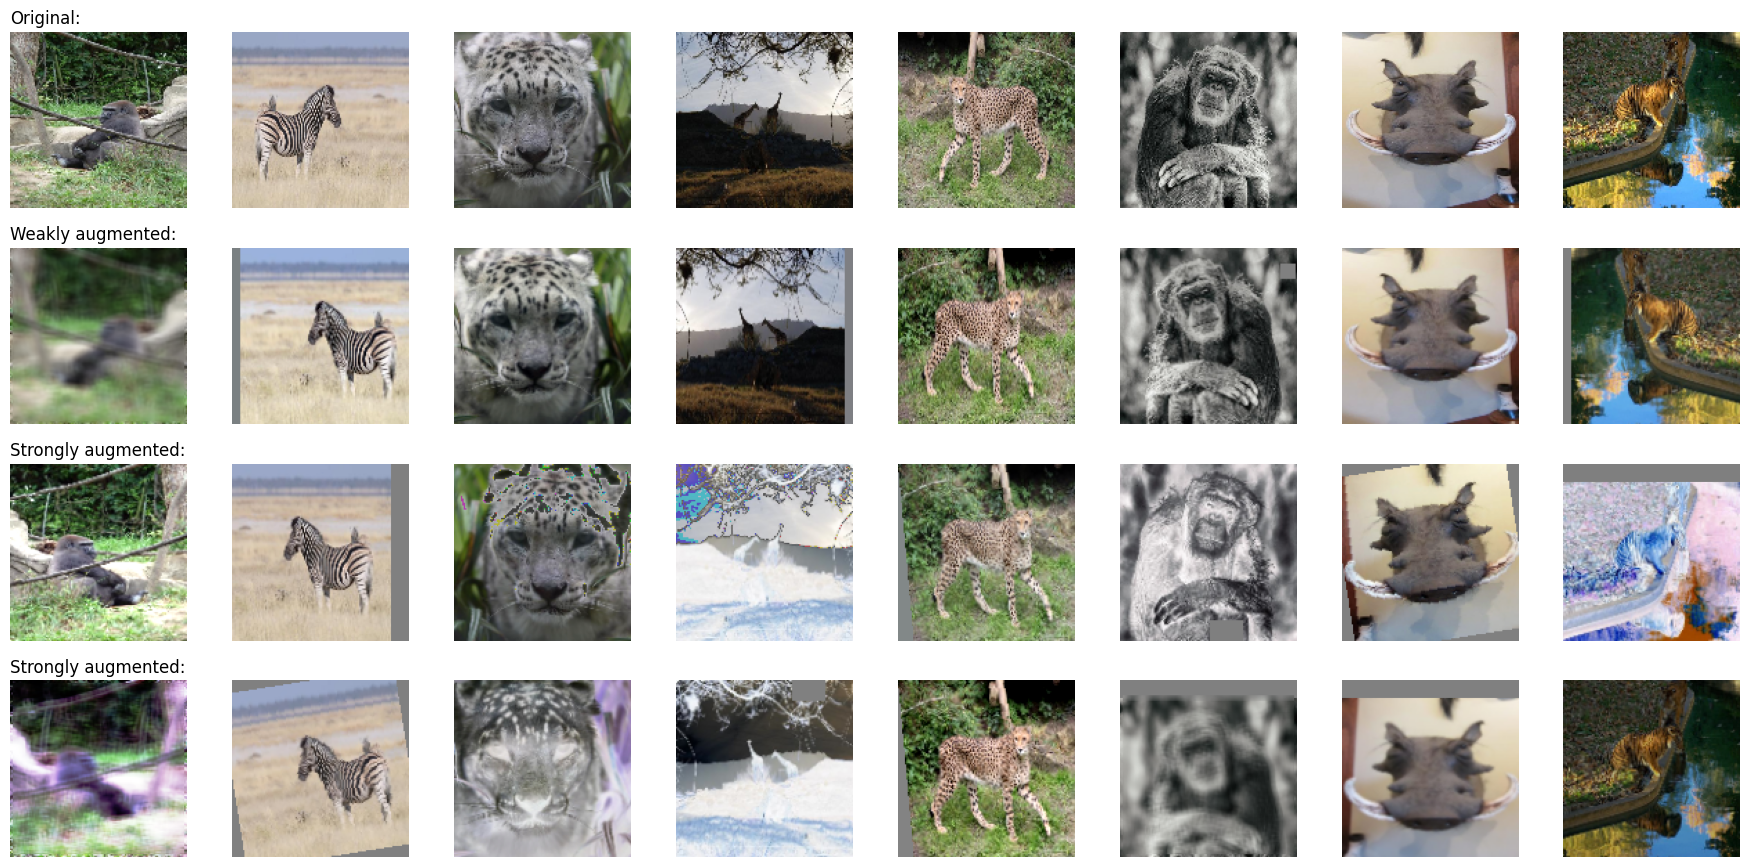

In [ ]:
visualize_augmentations(num_images=8)


In [ ]:
# Define the encoder architecture
def get_encoder():
    return keras.Sequential(
        [
            keras.Input(shape=IMG_SHAPE),
            tf.keras.applications.mobilenet.MobileNet(input_shape=IMG_SHAPE, classes=len(CLASSES), include_top=False, weights=None),
            layers.Flatten(),
            layers.Dense(width, activation="relu"),
        ],
        name="encoder",
    )


In [ ]:
# Baseline supervised training with random initialization
baseline_model = keras.Sequential(
    [
        keras.Input(shape=IMG_SHAPE),
        tf.keras.applications.mobilenet.MobileNet(input_shape=IMG_SHAPE, classes=len(CLASSES), include_top=False, weights=None),
        layers.Flatten(),
        layers.Dense(len(CLASSES)),
    ],
    name="baseline_model",
)

baseline_model.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="top1"),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="top3"),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top5")
    ],
)

baseline_model.summary()


Model: "baseline_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 16384)             0         
                                                                 
 dense_2 (Dense)             (None, 18)                294930    
                                                                 
Total params: 3,523,794
Trainable params: 3,501,906
Non-trainable params: 21,888
_________________________________________________________________


In [ ]:
def aug_fn(images):
    aug_img = aug_weak(images=images)
    return aug_img

def augment(images, labels):
    img_dtype = images.dtype
    img_shape = tf.shape(images)
    images = tf.numpy_function(aug_fn, [images], img_dtype)
    images = tf.reshape(images, shape = img_shape)
    return images, labels

baseline_history = baseline_model.fit(
    labeled_train_dataset.unbatch().batch(36).map(augment), epochs=100, 
    validation_data=test_dataset
)


Epoch 1/100
10/10 [==============================] - 8s 303ms/step - loss: 12.3375 - top1: 0.0722 - top3: 0.1694 - top5: 0.2833 - val_loss: 2.8913 - val_top1: 0.0556 - val_top3: 0.1667 - val_top5: 0.2778
Epoch 2/100
10/10 [==============================] - 2s 250ms/step - loss: 6.8263 - top1: 0.0361 - top3: 0.1722 - top5: 0.2833 - val_loss: 2.8982 - val_top1: 0.0556 - val_top3: 0.1667 - val_top5: 0.2778
Epoch 3/100
10/10 [==============================] - 3s 261ms/step - loss: 6.0062 - top1: 0.0472 - top3: 0.1667 - top5: 0.2806 - val_loss: 2.9045 - val_top1: 0.0556 - val_top3: 0.1667 - val_top5: 0.2778
Epoch 4/100
10/10 [==============================] - 3s 258ms/step - loss: 5.4714 - top1: 0.0694 - top3: 0.1750 - top5: 0.3222 - val_loss: 2.9130 - val_top1: 0.0556 - val_top3: 0.1667 - val_top5: 0.2778
Epoch 5/100
10/10 [==============================] - 3s 257ms/step - loss: 4.9303 - top1: 0.0806 - top3: 0.1972 - top5: 0.2750 - val_loss: 2.9553 - val_top1: 0.0556 - val_top3: 0.1667 - v

In [ ]:
# Define the contrastive model with model-subclassing
class ContrastiveModel(keras.Model):
    def __init__(self):
        super().__init__()

        self.temperature = temperature
        self.encoder = get_encoder()
        
        # Non-linear MLP as projection head
        self.projection_head = keras.Sequential(
            [
                keras.Input(shape=(width,)),
                layers.Dense(width, activation="relu"),
                layers.Dense(width),
            ],
            name="projection_head",
        )
        
        # Single dense layer for linear probing
        self.linear_probe = keras.Sequential(
            [layers.Input(shape=(width,)), layers.Dense(len(CLASSES))], name="linear_probe"
        )

        self.encoder.summary()
        self.projection_head.summary()
        self.linear_probe.summary()

    def compile(self, contrastive_optimizer, probe_optimizer, **kwargs):
        super().compile(**kwargs)

        self.contrastive_optimizer = contrastive_optimizer
        self.probe_optimizer = probe_optimizer

        # self.contrastive_loss will be defined as a method
        self.probe_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        self.contrastive_loss_tracker = keras.metrics.Mean(name="c_loss")
        self.contrastive_accuracy = keras.metrics.SparseCategoricalAccuracy(
            name="c_acc"
        )
        self.probe_loss_tracker = keras.metrics.Mean(name="p_loss")

        self.probe_accuracy = keras.metrics.SparseCategoricalAccuracy(name="top1")
        selif.top3_accuracy = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="top3")
        self.top5_accuracy = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top5")


    @property
    def metrics(self):
        return [
            self.contrastive_loss_tracker,
            self.contrastive_accuracy,
            self.probe_loss_tracker,
            self.probe_accuracy,
            self.top3_accuracy,
            self.top5_accuracy,
        ]

    def contrastive_loss(self, projections_1, projections_2):
        # InfoNCE loss (information noise-contrastive estimation)
        # NT-Xent loss (normalized temperature-scaled cross entropy)

        # Cosine similarity: the dot product of the l2-normalized feature vectors
        projections_1 = tf.math.l2_normalize(projections_1, axis=1)
        projections_2 = tf.math.l2_normalize(projections_2, axis=1)
        similarities = (
            tf.matmul(projections_1, projections_2, transpose_b=True) / self.temperature
        )

        # The similarity between the representations of two augmented views of the
        # same image should be higher than their similarity with other views
        batch_size = tf.shape(projections_1)[0]
        contrastive_labels = tf.range(batch_size)
        self.contrastive_accuracy.update_state(contrastive_labels, similarities)
        self.contrastive_accuracy.update_state(
            contrastive_labels, tf.transpose(similarities)
        )

        # The temperature-scaled similarities are used as logits for cross-entropy
        # a symmetrized version of the loss is used here
        loss_1_2 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, similarities, from_logits=True
        )
        loss_2_1 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, tf.transpose(similarities), from_logits=True
        )
        return (loss_1_2 + loss_2_1) / 2

    def train_step(self, data):
        (unlabeled_images, _), (labeled_images, labels) = data

        # Both labeled and unlabeled images are used, without labels
        images = tf.concat((unlabeled_images, labeled_images), axis=0)
        # Each image is augmented twice, differently
        augmented_images_1 = aug_strong(images=np.array(images))
        augmented_images_2 = aug_strong(images=np.array(images))
        with tf.GradientTape() as tape:
            features_1 = self.encoder(augmented_images_1, training=True)
            features_2 = self.encoder(augmented_images_2, training=True)
            # The representations are passed through a projection mlp
            projections_1 = self.projection_head(features_1, training=True)
            projections_2 = self.projection_head(features_2, training=True)
            contrastive_loss = self.contrastive_loss(projections_1, projections_2)
        gradients = tape.gradient(
            contrastive_loss,
            self.encoder.trainable_weights + self.projection_head.trainable_weights,
        )
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.encoder.trainable_weights + self.projection_head.trainable_weights,
            )
        )
        self.contrastive_loss_tracker.update_state(contrastive_loss)

        # Labels are only used in evalutation for an on-the-fly logistic regression
        preprocessed_images = aug_weak(images=np.array(images))
        with tf.GradientTape() as tape:
            # the encoder is used in inference mode here to avoid regularization
            # and updating the batch normalization paramers if they are used
            features = self.encoder(preprocessed_images, training=False)
            class_logits = self.linear_probe(features, training=True)
            probe_loss = self.probe_loss(labels, class_logits)
            # tf.print("labels: ", labels, summarize=-1)
            # tf.print("class_logits: ", class_logits, summarize=-1)
            # tf.print("probe_loss: ", probe_loss, summarize=-1)
        gradients = tape.gradient(probe_loss, self.linear_probe.trainable_weights)
        self.probe_optimizer.apply_gradients(
            zip(gradients, self.linear_probe.trainable_weights)
        )
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)
        self.top3_accuracy.update_state(labels, class_logits)
        self.top5_accuracy.update_state(labels, class_logits)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        labeled_images, labels = data

        # For testing the components are used with a training=False flag
        preprocessed_images = self.classification_augmenter(
            labeled_images, training=False
        )
        features = self.encoder(preprocessed_images, training=False)
        class_logits = self.linear_probe(features, training=False)
        probe_loss = self.probe_loss(labels, class_logits)
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)
        self.top3_accuracy.update_state(labels, class_logits)
        self.top5_accuracy.update_state(labels, class_logits)

        # Only the probe metrics are logged at test time
        return {m.name: m.result() for m in self.metrics[2:]}


In [ ]:
# Contrastive pretraining
pretraining_model = ContrastiveModel()

pretraining_model.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
    probe_optimizer=keras.optimizers.Adam(),
)


Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_16 (Flatten)        (None, 16384)             0         
                                                                 
 dense_16 (Dense)            (None, 128)               2097280   
                                                                 
Total params: 5,326,144
Trainable params: 5,304,256
Non-trainable params: 21,888
_________________________________________________________________
Model: "projection_head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 128)               16512     
                   

In [ ]:
pretraining_history = pretraining_model.fit(
    train_dataset, epochs=100, validation_data=test_dataset
)


Epoch 1/100
36/36 [==============================] - 123s 2s/step - c_loss: 4.5858 - c_acc: 0.0221 - p_loss: 3.3480 - top1: 0.0583 - top3: 0.1444 - top5: 0.2250 - val_p_loss: 3.2398 - val_top1: 0.0556 - val_top3: 0.1667 - val_top5: 0.2778
Epoch 2/100
36/36 [==============================] - 73s 2s/step - c_loss: 4.3233 - c_acc: 0.0345 - p_loss: 3.1677 - top1: 0.0444 - top3: 0.1500 - top5: 0.2639 - val_p_loss: 3.0327 - val_top1: 0.0556 - val_top3: 0.1667 - val_top5: 0.2778
Epoch 3/100
36/36 [==============================] - 73s 2s/step - c_loss: 4.1441 - c_acc: 0.0593 - p_loss: 3.3851 - top1: 0.0472 - top3: 0.1639 - top5: 0.2639 - val_p_loss: 3.3707 - val_top1: 0.0556 - val_top3: 0.1667 - val_top5: 0.2778
Epoch 4/100
36/36 [==============================] - 73s 2s/step - c_loss: 4.0228 - c_acc: 0.0749 - p_loss: 3.7335 - top1: 0.0389 - top3: 0.1361 - top5: 0.2361 - val_p_loss: 3.9840 - val_top1: 0.0556 - val_top3: 0.1667 - val_top5: 0.2778
Epoch 5/100
36/36 [============================

In [ ]:
# pretraining_model.save_weights('./pretraining_model_weights')
pretraining_model.load_weights('./pretraining_model_weights')


In [ ]:
# Supervised finetuning of the pretrained encoder
finetuning_model = keras.Sequential(
    [
        layers.Input(shape=IMG_SHAPE),
        get_augmenter(**classification_augmentation),
        pretraining_model.encoder,
        layers.Dense(len(CLASSES)),
    ],
    name="finetuning_model",
)
finetuning_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="top1"),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="top3"),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top5")
    ],
)

finetuning_history = finetuning_model.fit(
    labeled_train_dataset.unbatch().batch(30), epochs=100, validation_data=test_dataset
)


Epoch 1/100
12/12 [==============================] - 8s 318ms/step - loss: 73.9322 - top1: 0.0944 - top3: 0.2444 - top5: 0.3528 - val_loss: 99.8719 - val_top1: 0.0611 - val_top3: 0.2300 - val_top5: 0.3511
Epoch 2/100
12/12 [==============================] - 3s 260ms/step - loss: 25.3839 - top1: 0.1861 - top3: 0.4361 - top5: 0.5806 - val_loss: 95.9250 - val_top1: 0.1106 - val_top3: 0.2767 - val_top5: 0.4217
Epoch 3/100
12/12 [==============================] - 3s 260ms/step - loss: 12.0852 - top1: 0.3222 - top3: 0.6028 - top5: 0.7111 - val_loss: 71.7181 - val_top1: 0.1150 - val_top3: 0.2944 - val_top5: 0.4400
Epoch 4/100
12/12 [==============================] - 3s 282ms/step - loss: 8.0282 - top1: 0.4167 - top3: 0.6833 - top5: 0.7944 - val_loss: 70.8434 - val_top1: 0.1139 - val_top3: 0.2989 - val_top5: 0.4267
Epoch 5/100
12/12 [==============================] - 3s 282ms/step - loss: 6.3533 - top1: 0.4083 - top3: 0.7111 - top5: 0.8111 - val_loss: 61.7378 - val_top1: 0.1428 - val_top3: 0.3